In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Loading the image and returning it as a numpy array in grayscaly
def image_load(path):
    img = Image.open(path).convert('L')
    return np.array(img)

In [3]:
# creating a one-dimenational Guassian Mask
def gaussian_kernel_d(size, sigma):
    kernel = np.zeros(size)
    center = size // 2
    for i in range(size):
        dist = (i - center) ** 2
        kernel[i] = np.exp( -dist / (2 * sigma ** 2))
    return kernel / np.sum(kernel)



In [4]:
# creating a one-dimenational Guassian Mask
def gaussian_kernel_c(size, sigma):
    kernel = np.zeros(size)
    center = size // 2
    for i in range(size):
        dist = (i - center) ** 2
        kernel[i] = np.exp(-dist / (2 * sigma ** 2)) / (np.sqrt(2 * np.pi) * sigma)
    return kernel


In [5]:
# Create a 1D Gaussian derivative kernel for x and y directions
def gaussian_derivative_kernel_d(size, sigma):
    kernel = np.zeros(size)
    center = size // 2
    for i in range(size):
        dist = i - center
        kernel[i] = -dist * np.exp(-dist ** 2 / (2 * sigma**2))
    return kernel / np.sum(np.abs(kernel))



In [6]:
# Create a 1D Gaussian derivative kernel for x and y directions
def gaussian_derivative_kernel_c(size, sigma):
    kernel = np.zeros(size)
    center = size // 2
    for i in range(size):
        dist = i - center
        kernel[i] = (-dist * np.exp(-dist ** 2 / (2 * sigma**2))) / (np.sqrt(2 * np.pi) * sigma ** 3)
    return kernel


In [8]:
a = gaussian_kernel_d(13, 2)
b = gaussian_kernel_c(13, 2)
c = gaussian_derivative_kernel_d(13, 2)
d = gaussian_derivative_kernel_c(13, 2)
print(a, sum(a))
print(b, sum(b))
print(c, np.abs(c).sum())
print(d, np.abs(d).sum())

[0.0022182  0.00877313 0.02702316 0.06482519 0.12110939 0.17621312
 0.19967563 0.17621312 0.12110939 0.06482519 0.02702316 0.00877313
 0.0022182 ] 1.0
[0.00221592 0.00876415 0.02699548 0.0647588  0.12098536 0.17603266
 0.19947114 0.17603266 0.12098536 0.0647588  0.02699548 0.00876415
 0.00221592] 0.9989759025687457
[ 0.00855153  0.02818497  0.06945265  0.12495619  0.1556326   0.11322205
  0.         -0.11322205 -0.1556326  -0.12495619 -0.06945265 -0.02818497
 -0.00855153] 0.9999999999999999
[ 0.00332389  0.01095519  0.02699548  0.0485691   0.06049268  0.04400817
  0.         -0.04400817 -0.06049268 -0.0485691  -0.02699548 -0.01095519
 -0.00332389] 0.38868900544812107


In [63]:
# 1-Dimension Convolving for a given image and kernel across the X-axis
def convolve_x(image, kernel):
    image_height, image_width = image.shape
    kernel_size = kernel.shape[0]
    padding_size = kernel_size // 2
    padded_image = np.pad(image, padding_size, mode='constant', constant_values=0)
    output = np.zeros_like(image)
    
    for i in range(image_height):
        for j in range(image_width):
            region = padded_image[i+padding_size, j:j+kernel_size]
            output[i, j] = np.sum(region * kernel)
    
    return output

In [66]:
# 1-Dimension Convolving for a given image and kernel across the Y-axis
def convolve_y(image, kernel):
    image_height, image_width = image.shape
    kernel_size = kernel.shape[0]
    padding_size = kernel_size // 2
    padded_image = np.pad(image, padding_size, mode='constant', constant_values=0)
    output = np.zeros_like(image)
    
    for i in range(image_height):
        for j in range(image_width):
            region = padded_image[i:i+kernel_size, j+padding_size]
            output[i, j] = np.sum(region * kernel)
    
    return output

In [11]:
# Computing the gradient magnitude and direction
def compute_gradient_magnitude_and_direction(i_x, i_y):
    magnitude = np.sqrt(i_x ** 2 + i_y ** 2)
    direction = np.arctan2(i_y, i_x)
    return magnitude, direction


In [84]:
def non_maximum_suppression(magnitude, direction):
    # Step 1: Create an empty array for the output
    output = np.zeros_like(magnitude)
    
    # Step 2: Convert direction to degrees
    angle = np.rad2deg(direction) % 180  # Convert angles from radians to degrees and map them to [0, 180)
    
    # Step 3: Loop through height and width of an image and excluding the border pixels
    for i in range(1, magnitude.shape[0] - 1):  
        for j in range(1, magnitude.shape[1] - 1):  
            q, r = 255, 255  # Initialize neighboring magnitudes
            
            # Step 4: Compare the gradient direction and look at the neighbors
            # Angle 0 degrees (left/right neighbors)
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                # Right neighbor
                q = magnitude[i, j + 1]
                # Left neighbor  
                r = magnitude[i, j - 1]  
            # Angle 45 degrees (bottom-left/top-right diagonal)
            elif 22.5 <= angle[i, j] < 67.5:
                # Bottom-left diagonal neighbor
                q = magnitude[i + 1, j - 1] 
                # Top-right diagonal neighbor
                r = magnitude[i - 1, j + 1] 
            # Angle 90 degrees (top/bottom neighbors)
            elif 67.5 <= angle[i, j] < 112.5:
                # Bottom neighbor
                q = magnitude[i + 1, j]
                # Top neighbor
                r = magnitude[i - 1, j]
            # Angle 135 degrees (top-left/bottom-right diagonal)
            elif 112.5 <= angle[i, j] < 157.5:
                # Top-left diagonal neighbor
                q = magnitude[i - 1, j - 1]  
                # Bottom-right diagonal neighbor
                r = magnitude[i + 1, j + 1] 
            
            # Step 5: Suppress non-maxima
            if magnitude[i, j] >= q and magnitude[i, j] >= r:
                output[i, j] = magnitude[i, j]
            else:
                output[i, j] = 0
    
    return output


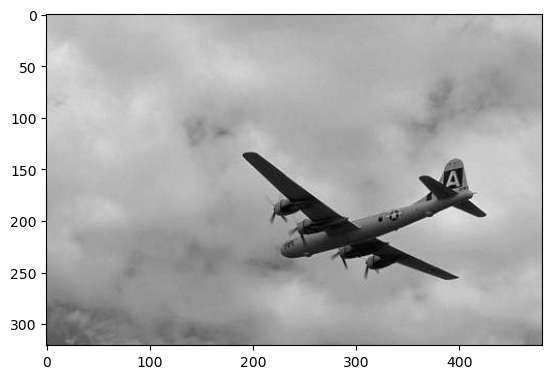

In [62]:
I1 = image_load('3096.jpg')
I1
plt.imshow(I1, cmap='gray')

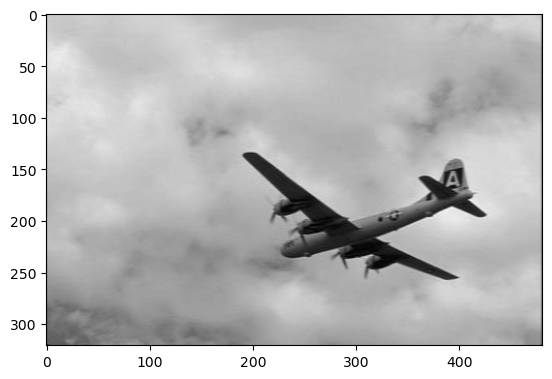

In [64]:
S_x = convolve_x(I1, gaussian_kernel_d(7, 1))
plt.imshow(S_x, cmap='gray')

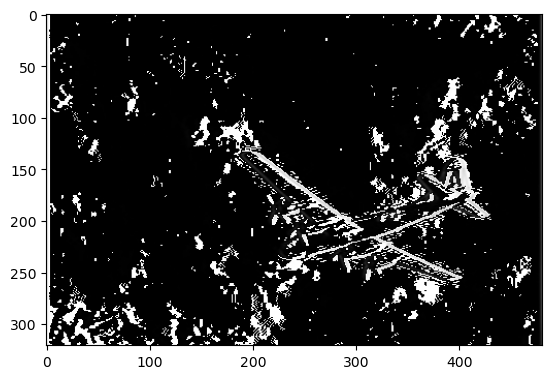

In [65]:
D_x = convolve_x(S_x, gaussian_derivative_kernel_d(7, 1))
plt.imshow(D_x, cmap='gray')

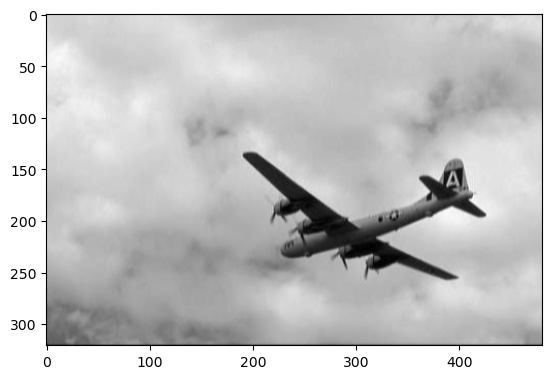

In [67]:
S_y = convolve_y(I1, gaussian_kernel_d(7, 1))
S_y
plt.imshow(S_y, cmap='gray')

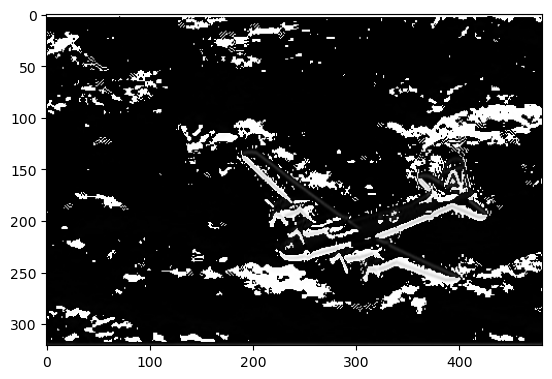

In [69]:
D_y = convolve_y(S_y, gaussian_derivative_kernel_d(7, 1))
plt.imshow(D_y, cmap='gray')

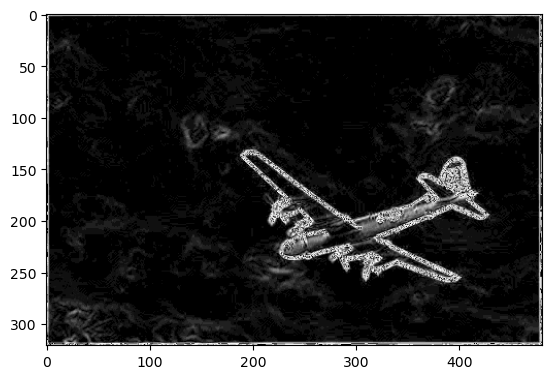

In [70]:
mag_1, dir_1 = compute_gradient_magnitude_and_direction(D_x, D_y)
#mag_1
plt.imshow(mag_1, cmap='gray')
#plt.imshow(dir_1)

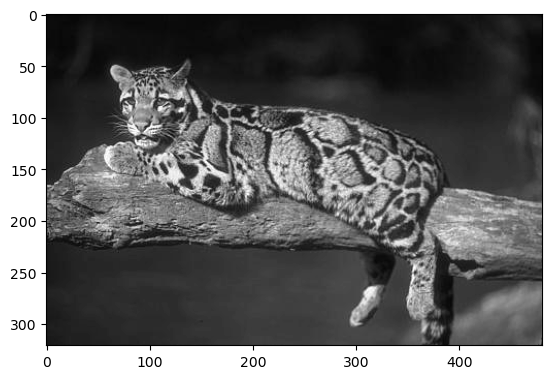

In [71]:
I2 = image_load('160068.jpg')
I2
plt.imshow(I2, cmap='gray')

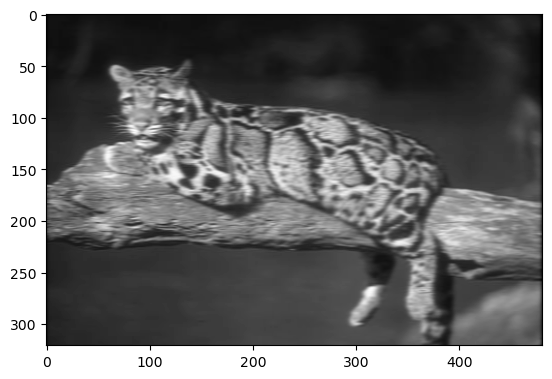

In [72]:
b = convolve_x(I2, gaussian_kernel_c(13, 2))
plt.imshow(b, cmap='gray')

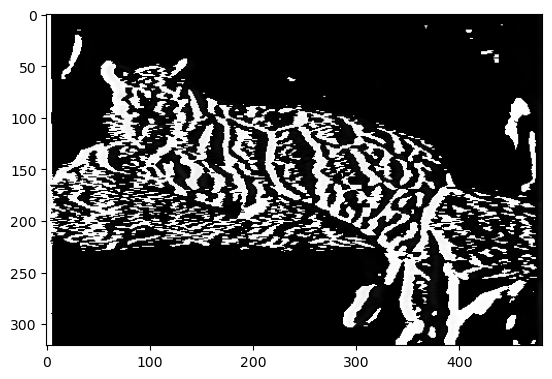

In [73]:
c = convolve_x(b, gaussian_derivative_kernel_c(13, 2))
plt.imshow(c, cmap='gray')

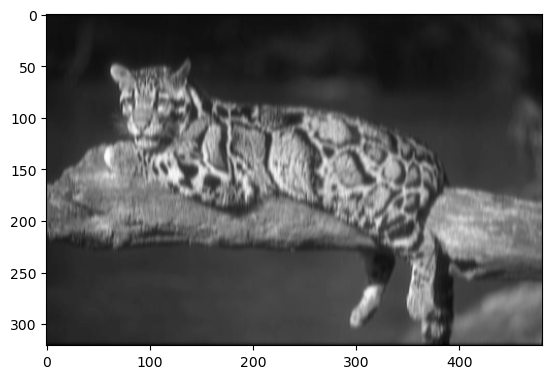

In [74]:
d = convolve_y(I2, gaussian_kernel_c(13, 2))
plt.imshow(d, cmap='gray')

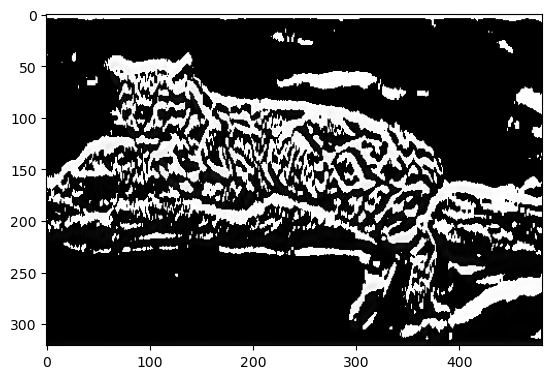

In [75]:
e = convolve_y(d, gaussian_derivative_kernel_c(13, 2))
plt.imshow(e, cmap='gray')

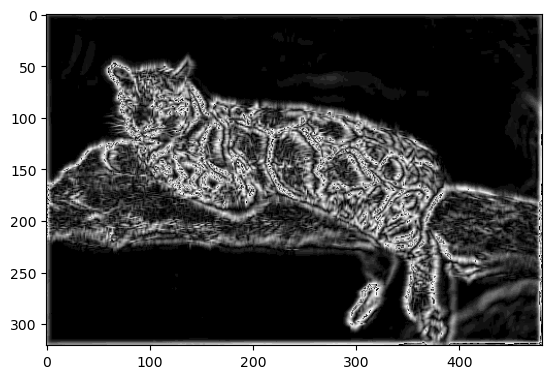

In [77]:
mag, dir = compute_gradient_magnitude_and_direction(c, e)
plt.imshow(mag, cmap='gray')
#plt.imshow(dir)

In [4]:
import numpy as np

def add_padding(image, kernel_size):
    """
    Adds zero padding to an image based on the kernel size.

    Parameters:
    - image: 2D numpy array representing the grayscale image.
    - kernel_size: Size of the kernel (should be an odd number).

    Returns:
    - padded_image: 2D numpy array with added padding.
    """
    # Calculate the padding size (half of the kernel size)
    pad_size = kernel_size // 2
    
    # Add padding to the image using np.pad
    # Mode 'constant' with constant_values=0 adds zero padding
    padded_image = np.pad(image, ((pad_size, pad_size), (pad_size, pad_size)), mode='constant', constant_values=0)
    
    return padded_image

# Example usage:
image = np.array([[1, 2, 3], 
                  [4, 5, 6], 
                  [7, 8, 9]])

kernel_size = 7
padded_image = add_padding(image, kernel_size)

print("Original Image:\n", image)
print("Padded Image:\n", padded_image)


Original Image:
 [[1 2 3]
 [4 5 6]
 [7 8 9]]
Padded Image:
 [[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 1 2 3 0 0 0]
 [0 0 0 4 5 6 0 0 0]
 [0 0 0 7 8 9 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


In [3]:
def convolve(image, kernel):
    padding_size = kernel.shape[0] // 2
    padded_image = np.pad(image, padding_size, mode='constant', constant_values=0)
    return padded_image

kernel_size = 7
padded_image = add_padding(image, kernel_size)

print("Original Image:\n", image)
print("Padded Image:\n", padded_image)

Original Image:
 [[1 2 3]
 [4 5 6]
 [7 8 9]]
Padded Image:
 [[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 1 2 3 0 0 0]
 [0 0 0 4 5 6 0 0 0]
 [0 0 0 7 8 9 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


In [5]:
import numpy as np

def compute_gradient_magnitude_direction(Ix, Iy):
    """
    Compute the gradient magnitude and direction for each pixel based on gradients in x and y directions.

    Parameters:
    - Ix: 2D numpy array representing the gradient in the x direction (result of convolve_x).
    - Iy: 2D numpy array representing the gradient in the y direction (result of convolve_y).

    Returns:
    - magnitude: 2D numpy array of the same shape as Ix and Iy, representing the gradient magnitude at each pixel.
    - direction: 2D numpy array of the same shape as Ix and Iy, representing the gradient direction at each pixel (in radians).
    """
    # Calculate the magnitude of the gradient at each pixel using the Pythagorean theorem
    magnitude = np.sqrt(Ix**2 + Iy**2)
    
    # Calculate the direction of the gradient (in radians)
    direction = np.arctan2(Iy, Ix)  # arctan2 handles the quadrants correctly
    
    return magnitude, direction

# Example usage:
# Assume Ix and Iy are the gradients calculated using convolve_x and convolve_y
Ix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])  # Example gradient in x direction
Iy = np.array([[9, 8, 7], [6, 5, 4], [3, 2, 1]])  # Example gradient in y direction

magnitude, direction = compute_gradient_magnitude_direction(Ix, Iy)

print("Gradient Magnitude:\n", magnitude)
print("Gradient Direction (in radians):\n", direction)


Gradient Magnitude:
 [[9.05538514 8.24621125 7.61577311]
 [7.21110255 7.07106781 7.21110255]
 [7.61577311 8.24621125 9.05538514]]
Gradient Direction (in radians):
 [[1.46013911 1.32581766 1.16590454]
 [0.98279372 0.78539816 0.5880026 ]
 [0.40489179 0.24497866 0.11065722]]
